In [13]:
%run metrics.py

In [22]:
import sys
sys.path.append('../DarkSide')
from blobify import *

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [24]:
def plot_voxels_side_by_side(voxel_datasets, titles, rows=0, cols=0, box_size=50):
    """
    Plot multiple 3D voxel grids in a single figure with a compact layout.

    Parameters:
    voxel_datasets (list of np.ndarray): List of 3D arrays representing voxel grids.
    titles (list of str): List of titles for the subplots.
    """
    if cols == 0 or rows == 0:
        num_plots = len(voxel_datasets)
        rows = int(np.ceil(num_plots / 3))  # 3-column layout
        cols = 3  

    fig = make_subplots(rows=rows, cols=cols, 
                        specs=[[{'type': 'scatter3d'}] * cols] * rows,
                        subplot_titles=titles)


    for i, (voxel_data, title) in enumerate(zip(voxel_datasets, titles)):
        row = (i // cols) + 1
        col = (i % cols) + 1
        x, y, z = np.where(voxel_data > 0)
        values = voxel_data[x, y, z] 

        scatter = go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=3, symbol='square', color=values, colorscale='Viridis', showscale=False),
            name=title
        )
        fig.add_trace(scatter, row=row, col=col)
        
        fig.update_scenes(
            dict(
                xaxis=dict(range=[-box_size, box_size], title="X"),
                yaxis=dict(range=[-box_size, box_size], title="Y"),
                zaxis=dict(range=[-box_size, box_size], title="Z"),
                aspectratio=dict(x=1, y=1, z=1),
                aspectmode='cube'
            ),
            row=row, col=col
        )

    #Adjust height and width of the figure
    fig.update_layout(
        height=300 * rows,   
        width=400 * cols,    
        title="Voxel Grids",
        margin=dict(l=10, r=10, t=50, b=10)  # Reduce padding around the plots
    )
    
    # config = {"displayModeBar": False}
    
    fig.show()

In [25]:
def compare_deferred(metrics):    #borrowed from the Dark side
    names = []
    elements = []
    symmetry_checks = {}

    def append(name, ab):
        names.append(name)
        elements.append(ab)
        for metric_name, metric_fn in metrics:      #symmetry check
            value_ab = metric_fn(ab[0], ab[1])
            value_ba = metric_fn(ab[1], ab[0])
            symmetry_checks[(name, metric_name)] = 1 if value_ab == value_ba else 0
        return [metric(*ab) for name, metric in metrics]

    def table():
        # Determine column widths for formatting
        longest_metric_name_len = max(len(name) for name, _ in metrics)
        longest_name_len = max(max(len(name) for name in names), 6)

        print(" " * longest_metric_name_len, "|", end=" ")
        for name in names:
            print(name + " " * (longest_name_len - len(name)), "|", end=" ")
        print("Symmetry" + " " * (longest_name_len - 8), "|")

        print("-" * (longest_metric_name_len + 2 + (len(names) + 1) * (longest_name_len + 3)))

        for metric_name, metric_fn in metrics:
            print(" " * (longest_metric_name_len - len(metric_name)) + metric_name, "|", end=" ")
            for i, (a, b) in enumerate(elements):
                value = repr(round(metric_fn(a, b), min(longest_name_len - 2, 4)))
                print(value + " " * (longest_name_len - len(value)), "|", end=" ")
            symmetry = all(symmetry_checks[(name, metric_name)] for name in names)
            print(f"{symmetry}       |")

    return append, table


metrics = [
    ("TVD", total_variation_distance),
    ("Wasserstein", wasserstein_dst_voxel),
    ("GMSD", gradient_magnitude_similarity_deviation),
    ("Q-Score", compute_q_score),
    ("Wasser 3D opt", wasserstein_distance_3d_optimized)
]

In [26]:
def create_ligand(shape, atoms, min=0, max=1):
    """
    Create a complex 3D blob using multiple Gaussian functions.

    Parameters:
    shape (tuple): Dimensions of the voxel grid (x, y, z).
    atoms (list of atoms): List of centers and sigmas for the Gaussian blobs.
    min (float): Lowest density value.
    max (float): Highest density value.

    Returns:
    np.ndarray: 3D array representing the voxel grid with blob values.
    """
    x = np.linspace(0, shape[0] - 1, shape[0])
    y = np.linspace(0, shape[1] - 1, shape[1])
    z = np.linspace(0, shape[2] - 1, shape[2])
    x, y, z = np.meshgrid(x, y, z, indexing='ij')

    blob = np.zeros(shape)
    for center, sigma in atoms:
        blob += np.exp(-((x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2) / (2 * sigma.mean() ** 2))

    blob -= blob.min()
    blob /= blob.max()

    blob *= (max - min)
    blob += min

    return blob

------------

Getting blobs with Gauss

In [27]:
def load_ligands(cif_file):
    """
    Input:
        cif_file - path to a cif file containing ligands
    Return:
        ligands - list of ligands
    """
    return extract_ligand_coords(cif_file)[0]

def load_blob(blob_file):
    """
    Input:
        blob_file - path to a npz file containing a blob
    Return:
        blob - voxel grind of the blob
    """
    return np.load(blob_file)["arr_0"]

In [47]:
def get_info(mapa,blob_npz, cif_ligand, ligand_name, treshold=0.005):
    map, scale, origin = load_map(mapa)
    blob = load_blob(blob_npz)
    # threshold = 0.005 # taken from Auto-Thresholding (https://github.com/DrDongSi/Auto-Thresholding)
    ligands = load_ligands(cif_ligand)
    # print(ligands.keys())
    ligand = ligands[ligand_name]
    offset, size = get_offset_and_size(ligand)
    atoms = ligand_to_atoms(ligand, offset, scale, origin)
    return atoms, blob


In [45]:
map = "data/emd_0199.map"
cif_ligand = "data/6hcy.cif"
blob_npz = "data/data/6HCY_C_502_HEM.npz"
ligand_name = "6hcy_C_502_HEM"

In [ ]:
get_info(map, blob_npz, cif_ligand, ligand_name)

----------------

Blobs from the dark side loaded 6HCY_C_502_HEM

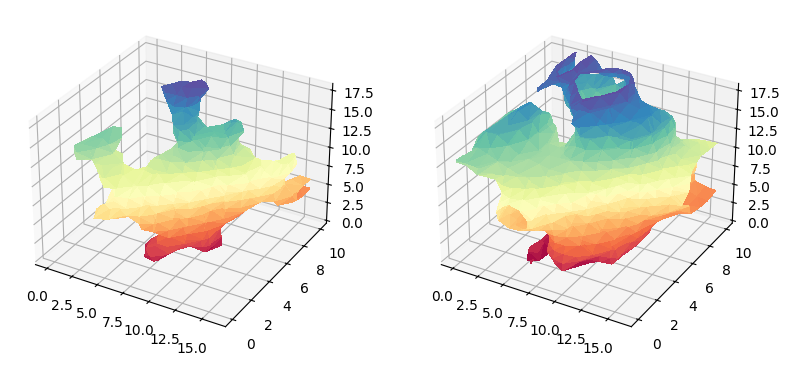

In [49]:
blob_atoms, blob = get_info(map, blob_npz, cif_ligand, ligand_name)
gaussian = create_ligand(blob.shape, blob_atoms, blob.min(), blob.max())
plot_blob_comparison(gaussian, blob)
plt.show()

In [57]:
compare_append, compare_table = compare_deferred([("TVD", total_variation_distance),
                                                  ("Wasserstein", wasserstein_dst_voxel),
                                                  ("GMSD", gradient_magnitude_similarity_deviation),
                                                  ("Q-Score", compute_q_score)])
compare_append("Gaussian", [gaussian, blob])

[0.960657154329567, 0.9637073072240584, 0.3883845537674615, 0.7875888181700006]

In [63]:
compare_append = f"Gaussian to Blob"

compare_table()

            | Gaussian | Symmetry |
-----------------------------------
        TVD | 0.9607   | True       |
Wasserstein | 0.9637   | True       |
       GMSD | 0.3884   | True       |
    Q-Score | 0.7876   | True       |


In [60]:
voxel_names, voxel_data = zip(*voxel_pairs)
plot_voxels_side_by_side(voxel_data, voxel_names, 2, 2)